## Install Detectron2


# 2 x customed Mosaic data augmentation (deleted tiny bouding boxes):
##     1. RandomRotate + CenterCrop (w/o artifact) || Transpose (Reflection) + RandomCrop 🦠
##     2. RandomCrop + random x_center and y_center 🦠

In [ ]:
!nvidia-smi -L

In [ ]:
!pip show albumentations

In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install -Uqqq pycocotools
# !pip install -U git+https://github.com/albumentations-team/albumentations

# Importing libraries


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from datetime import datetime
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import os, json, cv2, random, time, copy
import skimage.io as io
from pathlib import Path
from typing import Optional

import pycocotools.mask as mask_util
import itertools

import torch
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from glob import glob
import numba
from numba import jit

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.

# detectron2
import detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg, CfgNode
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data.datasets import register_coco_instances

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader, get_detection_dataset_dicts
from detectron2.data import detection_utils as utils
from detectron2.evaluation.evaluator import DatasetEvaluator
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

setup_logger()

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

# Loading Dataset

In [ ]:
dataDir = Path('../input/sartorius-cell-instance-segmentation/')
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'
register_coco_instances('sartorius_train',{}, '../input/sartorius-cell-instance-segmentation-coco/annotations_train.json', dataDir)
register_coco_instances('sartorius_val',{},'../input/sartorius-cell-instance-segmentation-coco/annotations_val.json', dataDir)

metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')
val_ds = DatasetCatalog.get('sartorius_val')

In [ ]:
metadata

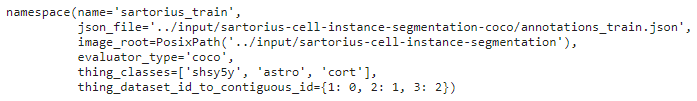

In [ ]:
# train_ds

In [ ]:
# type(train_ds[0]["annotations"][0]["category_id"])

In [ ]:
# train_ds[0]["annotations"][0]["category_id"] != 0
# train_ds[0]

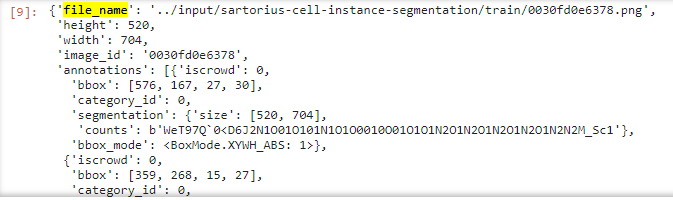

In [ ]:
# train_ds[1]

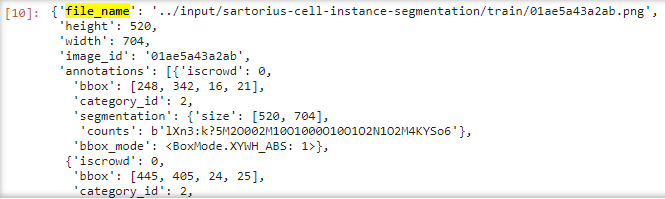

# (Augmented) Data Loader


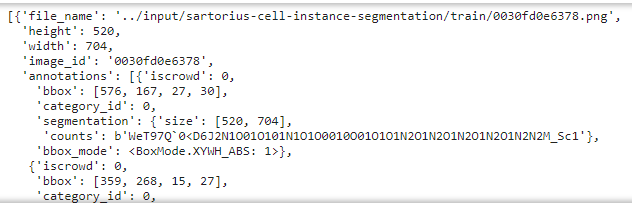

In [ ]:
Shsy5y_listOfdict, Astro_listOfdict, Cort_listOfdict = [], [], []
num_Shsy5y, num_Astro, num_Cort = 0, 0, 0
#shsy5y, astro, cort
for i in range(len(train_ds)):
    if train_ds[i]["annotations"][0]["category_id"] == 0:
        Shsy5y_listOfdict.append(train_ds[i])
        num_Shsy5y += 1
    elif train_ds[i]["annotations"][0]["category_id"] == 1:
        Astro_listOfdict.append(train_ds[i])
        num_Astro += 1
    elif train_ds[i]["annotations"][0]["category_id"] == 2:
        Cort_listOfdict.append(train_ds[i])
        num_Cort += 1
        
class_list = [Shsy5y_listOfdict, Astro_listOfdict, Cort_listOfdict]
num = [num_Shsy5y, num_Astro, num_Cort]

## *decode mask in (rle) coco format to Numpy array*

In [ ]:
'''
rle = [{'size': [520, 704], 'counts': '[dh61W`02N1O1O2N1N2O2N1N1000O100O010O1O100O100O1O010O1O100O001O100O010O10O0100O010O100O001OWQg3'}]
m = np.array(maskUtils.decode(rle), dtype=np.float32)
'''
def coco2Numpy_arr(annotations):
    #return: [gt_masks] + [gt_bboxes] + [classes]
    gt_masks = []
    gt_bboxes = []
    classes = []
    
    for i in range(len(annotations)):
        #gt_mask
        #decode mask in (rle) coco format to Numpy array
        rle = [{'size': [520, 704], 'counts': annotations[i]["segmentation"]["counts"]}]
        np_mask = np.array(mask_util.decode(rle), dtype=np.uint8)
        np_mask = np.reshape(np_mask,(520, 704))
        gt_masks.append(np_mask)
        
        #gt_bboxe
        gt_bboxes.append(annotations[i]["bbox"])
        
        #classes
        classes.append(annotations[i]["category_id"])
    
    return gt_masks, gt_bboxes, classes

## *Helper functions*

In [ ]:
# original image's size: rotate + centrer crop
ROTATED_CENTRER_CROP = A.Compose([
                        A.Rotate(limit=175, border_mode=1, p=1.0),
                        A.CenterCrop(height=325, width=440, p=1.0),  #(325/440 = 65/85 = 520/704)
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["bbox_classes"])) 

# original image's size: transpose + random crop
TRANSPOSE_RANDOM_CROP = A.Compose([
                        A.Transpose(p=1.0),
                        A.RandomCrop(height=325, width=440, p=1.0),  #(325/440 = 65/85 = 520/704)
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["bbox_classes"])) 

def is_tiny_box(height, width, min_area=30):
    return True if height * width < min_area else False

def create_a_mosaic_set(image_list, xc, yc, H_mosaic_img, W_mosaic_img):
    mosaic_image = np.full((H_mosaic_img, W_mosaic_img, 3), 1, dtype=np.uint8) 
    mosaic_bboxes, mosaic_masks, mosaic_bbox_classes = [], [], []        

    for i, image_set in enumerate(image_list):
#         print("sub-image ", i + 1, ": ", image_set["image"].shape)
#         plt.imshow(image_set["image"])
#         plt.show()
        
        shape = image_set["image"].shape
        if i == 0: #top-left
            mosaic_image[0:yc, 0:xc, :] = image_set["image"]
            for box, mask, bbox_class in zip(image_set["bboxes"], image_set["masks"], image_set["bbox_classes"]):
                box = list(box)
                # "pascal_voc" to "coco"
                box[2] -= box[0]
                box[3] -= box[1]
                assert box[0] < xc and box[1] < yc and box[2] <= xc and box [3] <= yc, f"sub-image shape: {shape} || box: {box}"
                if is_tiny_box(*box[2:]):
                    continue
                mosaic_bboxes.append(box)
                
                mosaic_mask = np.full((H_mosaic_img, W_mosaic_img), 0, dtype=np.uint8)
                mosaic_mask[0:yc, 0:xc] = mask
                mosaic_masks.append(mosaic_mask)
                mosaic_bbox_classes.append(bbox_class)
        elif i == 1: #top-right
            mosaic_image[0:yc, xc:, :] = image_set["image"]
            for box, mask, bbox_class in zip(image_set["bboxes"], image_set["masks"], image_set["bbox_classes"]):
                box = list(box)
                # "pascal_voc" to "coco"
                box[2] -= box[0]
                box[3] -= box[1]
                if is_tiny_box(*box[2:]):
                    continue
                assert box[0] < W_mosaic_img - xc and box[1] < yc and box[2] <= W_mosaic_img - xc and box [3] <= yc, f"sub-image shape: {shape} || box: {box}"
                box[0] += xc
                mosaic_bboxes.append(box)
                
                mosaic_mask = np.full((H_mosaic_img, W_mosaic_img), 0, dtype=np.uint8)
                mosaic_mask[0:yc, xc:] = mask
                mosaic_masks.append(mosaic_mask)
                mosaic_bbox_classes.append(bbox_class)
        elif i == 2: #bottom-left
            mosaic_image[yc:, 0:xc, :] = image_set["image"]
            for box, mask, bbox_class in zip(image_set["bboxes"], image_set["masks"], image_set["bbox_classes"]):
                box = list(box)
                # "pascal_voc" to "coco"
                box[2] -= box[0]
                box[3] -= box[1]
                assert box[0] < xc and box[1] < H_mosaic_img - yc and box[2] <= xc and box [3] <= H_mosaic_img - yc, f"sub-image shape: {shape} || box: {box}"
                if is_tiny_box(*box[2:]):
                    continue
                box[1] += yc
                mosaic_bboxes.append(box)
                
                mosaic_mask = np.full((H_mosaic_img, W_mosaic_img), 0, dtype=np.uint8)
                mosaic_mask[yc:, 0:xc] = mask
                mosaic_masks.append(mosaic_mask)
                mosaic_bbox_classes.append(bbox_class)
        else:      #bottom-right
            mosaic_image[yc:, xc:, :] = image_set["image"]
            for box, mask, bbox_class in zip(image_set["bboxes"], image_set["masks"], image_set["bbox_classes"]):
                box = list(box)
                # "pascal_voc" to "coco"
                box[2] -= box[0]
                box[3] -= box[1]
                if is_tiny_box(*box[2:]):
                    continue
                assert box[0] < W_mosaic_img - xc and box[1] < H_mosaic_img - yc and box[2] <= W_mosaic_img - xc and box [3] <= H_mosaic_img - yc, f"sub-image shape: {shape} || box: {box}"
                box[0] += xc
                box[1] += yc
                mosaic_bboxes.append(box)

                mosaic_mask = np.full((H_mosaic_img, W_mosaic_img), 0, dtype=np.uint8)
                mosaic_mask[yc:, xc:] = mask
                mosaic_masks.append(mosaic_mask)
                mosaic_bbox_classes.append(bbox_class)

    return mosaic_image, mosaic_masks, mosaic_bboxes, mosaic_bbox_classes

## *AlbumentationsMapper*
preparation for randomly read 3 images:
+ list of shsy5y -> randomly read 1 images
+ list of cort and astro -> randomly read 2 images

read 4 original images + horizontal flip + vertical flip (light)

+ p=0.4:
    #original image
+ p=0.6:
    + p=0.5:
        #customed mosaic with 4 "rotate + centrer crop" or "transpose + random crop": 4 images (height=325, width=440)
    + p=0.5:
        #mosaic with 4 original images: 4 images (random height and width)

In [ ]:
def AlbumentationsMapper(dataset_dict):
    # READ IMAGE 1:
    dataset_dict = copy.deepcopy(dataset_dict)
    image_1 = utils.read_image(dataset_dict["file_name"])
    image_1 = np.stack((image_1, image_1, image_1)) #(3, 520, 704)
    image_1 = image_1.transpose(1, 2, 0) #(520, 704, 3)
    gt_masks_1, gt_bboxes_1, classes_1 = coco2Numpy_arr(dataset_dict["annotations"])
    
    if random.random() < 0.6:
        #FINAL
        n_height = np.random.choice([640, 672, 704, 736, 768, 800])
        n_width = int((n_height * 704 / 520) + 0.5)
        FINAL = A.Compose([
                            A.HorizontalFlip(p=0.5),
                            A.VerticalFlip(p=0.5),
                            A.Resize(height=n_height, width=n_width, p=1.0),
                            ToTensorV2(p=1.0),
                            ], bbox_params=A.BboxParams(format="coco", label_fields=["bbox_classes"]))
        transformed = FINAL(image=image_1, masks=gt_masks_1, bboxes=gt_bboxes_1, bbox_classes=classes_1)
        transformed_image, transformed_masks, transformed_bboxes, transformed_bbox_classes = \
        transformed["image"], transformed["masks"], transformed["bboxes"], transformed["bbox_classes"]
    else: 
        # dataset_dict_2, dataset_dict_3, dataset_dict_4 of 3 images with same cell type. 
        cell_type = classes_1[0]
        listOfdict = class_list[cell_type]
        num_dict = num[cell_type]
        dataset_dict_2 = copy.deepcopy(listOfdict[random.randint(0, num_dict - 1)])
        dataset_dict_3 = copy.deepcopy(listOfdict[random.randint(0, num_dict - 1)])
        dataset_dict_4 = copy.deepcopy(listOfdict[random.randint(0, num_dict - 1)])
        del listOfdict
        # READ 3 IMAGES + CHANGE BBOX FORMAT FROM "coco" TO "pascal_voc": (because of the Albumentations's bug)
        # IMAGE 1:
        for idx, box in enumerate(gt_bboxes_1):
            gt_bboxes_1[idx][2] += box[0]
            gt_bboxes_1[idx][3] += box[1]
        # IMAGE 2:
        image_2 = utils.read_image(dataset_dict_2["file_name"])
        image_2 = np.stack((image_2, image_2, image_2)) #(3, 520, 704)
        image_2 = image_2.transpose(1, 2, 0) #(520, 704, 3)
        gt_masks_2, gt_bboxes_2, classes_2 = coco2Numpy_arr(dataset_dict_2["annotations"])
        for idx, box in enumerate(gt_bboxes_2):
            gt_bboxes_2[idx][2] += box[0]
            gt_bboxes_2[idx][3] += box[1]
        # IMAGE 3:
        image_3 = utils.read_image(dataset_dict_3["file_name"])
        image_3 = np.stack((image_3, image_3, image_3)) #(3, 520, 704)
        image_3 = image_3.transpose(1, 2, 0) #(520, 704, 3)
        gt_masks_3, gt_bboxes_3, classes_3 = coco2Numpy_arr(dataset_dict_3["annotations"])
        for idx, box in enumerate(gt_bboxes_3):
            gt_bboxes_3[idx][2] += box[0]
            gt_bboxes_3[idx][3] += box[1]
        # IMAGE 4:
        image_4 = utils.read_image(dataset_dict_4["file_name"])
        image_4 = np.stack((image_4, image_4, image_4)) #(3, 520, 704)
        image_4 = image_4.transpose(1, 2, 0) #(520, 704, 3)
        gt_masks_4, gt_bboxes_4, classes_4 = coco2Numpy_arr(dataset_dict_4["annotations"])
        for idx, box in enumerate(gt_bboxes_4):
            gt_bboxes_4[idx][2] += box[0]
            gt_bboxes_4[idx][3] += box[1]

        # CUSTOMED_MOSAIC: 4 images (height=325, width=440) & "rotate + centrer crop" or "transpose + random crop" -> height=650, width=880
        if random.random() < 0.5: 
            image_list = []
            # IMAGE 1:
            transformed = ROTATED_CENTRER_CROP(image=image_1, masks=gt_masks_1, bboxes=gt_bboxes_1, bbox_classes=classes_1)
            image_list.append({"image": transformed["image"], "masks": transformed["masks"], 
                               "bboxes": transformed["bboxes"], "bbox_classes": transformed["bbox_classes"]})
            # IMAGE 2:
            transformed = ROTATED_CENTRER_CROP(image=image_2, masks=gt_masks_2, bboxes=gt_bboxes_2, bbox_classes=classes_2)
            image_list.append({"image": transformed["image"], "masks": transformed["masks"], 
                               "bboxes": transformed["bboxes"], "bbox_classes": transformed["bbox_classes"]})
            # IMAGE 3:
            transformed = TRANSPOSE_RANDOM_CROP(image=image_3, masks=gt_masks_3, bboxes=gt_bboxes_3, bbox_classes=classes_3)
            image_list.append({"image": transformed["image"], "masks": transformed["masks"], 
                               "bboxes": transformed["bboxes"], "bbox_classes": transformed["bbox_classes"]})
            # IMAGE 4:
            transformed = TRANSPOSE_RANDOM_CROP(image=image_4, masks=gt_masks_4, bboxes=gt_bboxes_4, bbox_classes=classes_4)
            image_list.append({"image": transformed["image"], "masks": transformed["masks"], 
                               "bboxes": transformed["bboxes"], "bbox_classes": transformed["bbox_classes"]})
            # CUSTOMED MOSAIC SET:
            random.shuffle(image_list)
            inf = {"xc": 440, "yc": 325, "H_mosaic_img": 650, "W_mosaic_img": 880}
            cus_mosaic_image, cus_mosaic_masks, cus_mosaic_bboxes, cus_mosaic_bbox_classes = create_a_mosaic_set(image_list, **inf)
            
#             print("CUSTOM MOSAIC DONE!: ", cus_mosaic_image.shape)
#             plt.imshow(cus_mosaic_image)
#             plt.show()
            # FINAL:
            n_height = np.random.choice([672, 704, 736, 768, 800])
            n_width = int((n_height * 704 / 520) + 0.5)
            FINAL = A.Compose([
                                A.Resize(height=n_height, width=n_width, p=1.0),
                                ToTensorV2(p=1.0),
                                ], bbox_params=A.BboxParams(format="coco", label_fields=["bbox_classes"]))
            transformed = FINAL(image=cus_mosaic_image, masks=cus_mosaic_masks, bboxes=cus_mosaic_bboxes, bbox_classes=cus_mosaic_bbox_classes)
            transformed_image, transformed_masks, transformed_bboxes, transformed_bbox_classes = \
            transformed["image"], transformed["masks"], transformed["bboxes"], transformed["bbox_classes"]
            
        # MOSAIC: 4 images & "random height and width" + "random crop" -> height=715, width=968
        else:
            image_list = []
            H_mosaic = 715
            W_mosaic = 968
            xc = int(random.uniform(430, 538)) # W_mosaic - 430
            yc = int(random.uniform(310, 405)) # H_mosaic - 310
            # IMAGE 1: top-left
            RANDOM_CROP = A.Compose([
                                A.RandomCrop(height=yc, width=xc, p=1),
                                A.HorizontalFlip(p=0.5),
                                A.VerticalFlip(p=0.5),
                                ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["bbox_classes"]))
            transformed = RANDOM_CROP(image=image_1, masks=gt_masks_1, bboxes=gt_bboxes_1, bbox_classes=classes_1)
            image_list.append({"image": transformed["image"], "masks": transformed["masks"], 
                               "bboxes": transformed["bboxes"], "bbox_classes": transformed["bbox_classes"]})
            # IMAGE 2: top-right
            RANDOM_CROP = A.Compose([
                                A.RandomCrop(height=yc, width=W_mosaic-xc, p=1),
                                A.HorizontalFlip(p=0.5),
                                A.VerticalFlip(p=0.5),
                                ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["bbox_classes"]))
            transformed = RANDOM_CROP(image=image_2, masks=gt_masks_2, bboxes=gt_bboxes_2, bbox_classes=classes_2)
            image_list.append({"image": transformed["image"], "masks": transformed["masks"], 
                               "bboxes": transformed["bboxes"], "bbox_classes": transformed["bbox_classes"]})
            # IMAGE 3: bottom-left
            RANDOM_CROP = A.Compose([
                                A.RandomCrop(height=H_mosaic-yc, width=xc, p=1),
                                A.HorizontalFlip(p=0.5),
                                A.VerticalFlip(p=0.5),
                                ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["bbox_classes"]))
            transformed = RANDOM_CROP(image=image_3, masks=gt_masks_3, bboxes=gt_bboxes_3, bbox_classes=classes_3)
            image_list.append({"image": transformed["image"], "masks": transformed["masks"], 
                               "bboxes": transformed["bboxes"], "bbox_classes": transformed["bbox_classes"]})
            # IMAGE 4: bottom-right
            RANDOM_CROP = A.Compose([
                                A.RandomCrop(height=H_mosaic-yc, width=W_mosaic-xc, p=1),
                                A.HorizontalFlip(p=0.5),
                                A.VerticalFlip(p=0.5),
                                ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["bbox_classes"]))
            transformed = RANDOM_CROP(image=image_4, masks=gt_masks_4, bboxes=gt_bboxes_4, bbox_classes=classes_4)
            image_list.append({"image": transformed["image"], "masks": transformed["masks"], 
                               "bboxes": transformed["bboxes"], "bbox_classes": transformed["bbox_classes"]})
            # MOSAIC SET:
            inf = {"xc": xc, "yc": yc, "H_mosaic_img": 715, "W_mosaic_img": 968}
            mosaic_image, mosaic_masks, mosaic_bboxes, mosaic_bbox_classes = create_a_mosaic_set(image_list, **inf)
            
#             print("MOSAIC DONE!: ", mosaic_image.shape)
#             plt.imshow(mosaic_image)
#             plt.show()

            # FINAL:
            n_height = np.random.choice([736, 768, 800])
            n_width = int((n_height * 704 / 520) + 0.5)
            FINAL = A.Compose([
                                A.Resize(height=n_height, width=n_width, p=1.0),
                                ToTensorV2(p=1.0),
                                ], bbox_params=A.BboxParams(format="coco", label_fields=["bbox_classes"]))
            transformed = FINAL(image=mosaic_image, masks=mosaic_masks, bboxes=mosaic_bboxes, bbox_classes=mosaic_bbox_classes)
            transformed_image, transformed_masks, transformed_bboxes, transformed_bbox_classes = \
            transformed["image"], transformed["masks"], transformed["bboxes"], transformed["bbox_classes"]
    
    annos = [] #(list[dict]) – a list of instance annotations in one image, each element for one instance: “gt_boxes”, “gt_classes”, “gt_masks”.
    for gt_box, gt_class, gt_mask in zip(transformed_bboxes, transformed_bbox_classes, transformed_masks):
        instance_annotations = {'bbox': gt_box, 'bbox_mode': dataset_dict["annotations"][0]["bbox_mode"], 'category_id': gt_class, 'segmentation': gt_mask}
        annos.append(instance_annotations)
    final_dataset_dict = {'image': transformed_image, 'height': n_height, 'width': n_width} 
#     “image”: Tensor in (C, H, W) format. The meaning of channels are defined by cfg.INPUT.FORMAT. Image normalization, if any, will be performed inside the model using cfg.MODEL.PIXEL_{MEAN,STD}.
    
    instances = utils.annotations_to_instances(annos, image_size=(n_height, n_width), mask_format='bitmask')
    final_dataset_dict["instances"] = utils.filter_empty_instances(instances) 

#     aug_image = transformed_image.permute(1, 2, 0).cpu().detach().numpy()
#     print("augmented image: ", aug_image.shape)
#     plt.imshow(aug_image)
#     plt.show()
    return final_dataset_dict

# Evaluator

In [ ]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

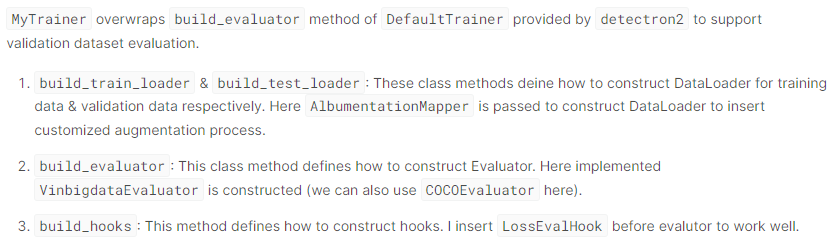

## *New Mytrainer*

In [ ]:
# class MyTrainer(DefaultTrainer):
#     @classmethod
#     def build_train_loader(cls, cfg):
#         min_size = cfg.INPUT.MIN_SIZE_TRAIN
#         max_size = cfg.INPUT.MAX_SIZE_TRAIN
#         sample_style = cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING

#         mapper = AlbumentationsMapper

#         dataset  = get_detection_dataset_dicts(
#                     cfg.DATASETS.TRAIN,
#                     filter_empty=cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS,
#                     min_keypoints=cfg.MODEL.ROI_KEYPOINT_HEAD.MIN_KEYPOINTS_PER_IMAGE if cfg.MODEL.KEYPOINT_ON else 0,
#                     proposal_files=cfg.DATASETS.PROPOSAL_FILES_TRAIN if cfg.MODEL.LOAD_PROPOSALS else None,
#                 )

#         sampler = detectron2.data.samplers.distributed_sampler.TrainingSampler(len(dataset))

#         return build_detection_train_loader(
#                                               dataset=dataset, 
#                                               mapper=mapper, 
#                                               sampler=sampler, 
#                                               total_batch_size=cfg.SOLVER.IMS_PER_BATCH, 
#                                               aspect_ratio_grouping=False, 
#                                               num_workers=4)
    
#     @classmethod
#     def build_evaluator(cls, cfg, dataset_name, output_folder=None):
#         return MAPIOUEvaluator(dataset_name)
#     def build_hooks(self):
#         # copy of cfg
#         cfg = self.cfg.clone()
#         # build the original model hooks
#         hooks = super().build_hooks()
#         # add the best checkpointer hook
#         hooks.insert(-1, BestCheckpointer(cfg.TEST.EVAL_PERIOD, 
#                                          DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
#                                          "MaP IoU",
#                                          "max",
#                                          ))
#         return hooks

## *Old MyTrainer*

In [ ]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=AlbumentationsMapper)
#     @classmethod
#     def build_test_loader(cls, cfg):
#         return build_detection_test_loader(cfg, mapper=DatasetMapper(cfg, 
#                                                                       is_train=False, 
#                                                                       augmentations=[
#                                                                                     T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
#                                                                                     T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
#                                                                                    ]))
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)
    def build_hooks(self):

        # copy of cfg
        cfg = self.cfg.clone()

        # build the original model hooks
        hooks = super().build_hooks()

        # add the best checkpointer hook
        hooks.insert(-1, BestCheckpointer(cfg.TEST.EVAL_PERIOD, 
                                         DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                                         "MaP IoU",
                                         "max",
                                         ))
        return hooks

# Training + cfg

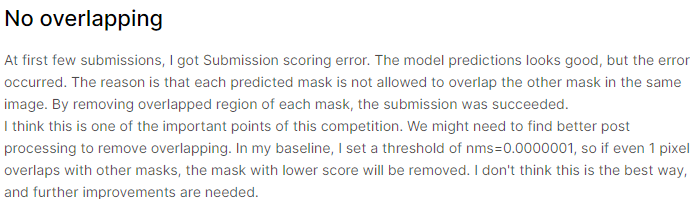

## *New "cfg"*

### dataset_dict
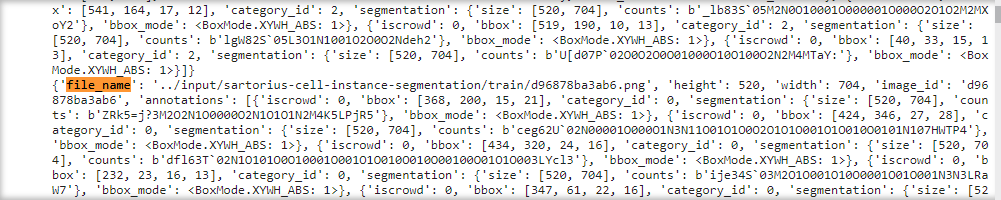

In [ ]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
# cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sartorius_train",)
cfg.DATASETS.TEST = ("sartorius_val",)
cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = '../input/stage1-iter38519-map-0-291/stage1_iter38519_map_0_291.pth'  # Let training initialize from the pretrained model
cfg.MODEL.WEIGHTS = '../input/stage1-model-best-256/stage1_model_best_256.pth'  # Let training initialize from the pretrained model
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml")
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")


cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0004 #0.001
cfg.SOLVER.MAX_ITER = 1 # 15000
cfg.SOLVER.CHECKPOINT_PERIOD = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH * 10 # Once per epoch
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256 #128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.TEST.EVAL_PERIOD = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch
cfg.SOLVER.STEPS = (4000, 10000, 14000,)  

#NEW
cfg.SOLVER.GAMMA = 0.5
cfg.INPUT.RANDOM_FLIP = "none"
# cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_TYPE = "diou"               #<--------------------------------------NEED TO TUNE !!!
# cfg.MODEL.RPN.BBOX_REG_LOSS_TYPE = "diou"              #<--------------------------------------NEED TO TUNE !!!
cfg.SOLVER.WARMUP_ITERS = 0

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

## *Old "cfg"*

In [ ]:
# cfg = get_cfg()
# config_name = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml" 
# cfg.merge_from_file(model_zoo.get_config_file(config_name))
# cfg.DATASETS.TRAIN = (Data_Resister_training,)
# cfg.DATASETS.TEST = (Data_Resister_valid,)
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo

# #cfg.INPUT.FORMAT = "L"
# # Mode for flipping images used in data augmentation during training
# # choose one of ["horizontal, "vertical", "none"]
# #cfg.INPUT.RANDOM_FLIP = "none"
# # Size of the smallest side of the image during training
# cfg.INPUT.MIN_SIZE_TRAIN = (325, 390, 455, 520, 585, 650, 715)                                     #<--------------------------------------NEED TO TUNE !!!
# # Sample size of smallest side by choice or random selection from range give by
# # INPUT.MIN_SIZE_TRAIN
# cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING = "choice"
# # Maximum size of the side of the image during training
# cfg.INPUT.MAX_SIZE_TRAIN = 1000 #704
# # Size of the smallest side of the image during testing. Set to zero to disable resize in testing.
# cfg.INPUT.MIN_SIZE_TEST = 520
# # Maximum size of the side of the image during testing
# cfg.INPUT.MAX_SIZE_TEST = 1000 #704


# cfg.DATALOADER.NUM_WORKERS = 4
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
# cfg.SOLVER.IMS_PER_BATCH = 2 
# cfg.INPUT.MASK_FORMAT = 'bitmask'
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# # cfg.MODEL.RPN.NMS_THRESH = 0.0000001
# # cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_TYPE = "diou"               #<--------------------------------------NEED TO TUNE !!!
# # cfg.MODEL.RPN.BBOX_REG_LOSS_TYPE = "diou"              #<--------------------------------------NEED TO TUNE !!!
# # cfg.MODEL.RPN.BBOX_REG_LOSS_WEIGHT = 10.0              #<--------------------------------------NEED TO TUNE !!!
# # cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_WEIGHT = 10.0              #<--------------------------------------NEED TO TUNE !!!

# cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"        #<--------------------------------------NEED TO TUNE !!!
# cfg.SOLVER.BASE_LR = 0.001 #0.0005 #(quite high base learning rate but should drop)              #<--------------------------------------NEED TO TUNE !!!
# #How many iterations to go from 0 to reach base LR
# cfg.SOLVER.WARMUP_ITERS = 1000 
# # NUM_EPOCH = MAX_ITER * IMS_PER_BATCH / TOTAL_NUM_IMAGES
# cfg.SOLVER.MAX_ITER = 15000   
# # The iteration number to decrease learning rate by GAMMA.
# cfg.SOLVER.STEPS = (14000,)     #<--------------------------------------NEED TO TUNE !!!
# cfg.TEST.EVAL_PERIOD = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch
# cfg.SOLVER.CHECKPOINT_PERIOD = cfg.TEST.EVAL_PERIOD * 5


# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = MyTrainer(cfg) # with  data augmentation  
# trainer.resume_or_load(resume=False)
# trainer.train()

# Evaluator
* Famouns dataset's evaluator is already implemented in detectron2.
* For example, many kinds of AP (Average Precision) are calculted in COCOEvaluator.
* **COCOEvaluator calculates AP with IoU from 0.50 to 0.95**

In [ ]:
evaluator = COCOEvaluator(Data_Resister_valid, cfg, False, output_dir="./output/")
cfg.MODEL.WEIGHTS="../input/detectron2cell/output/model_final.pth"
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
#cfg.INPUT.MASK_FORMAT='polygon'
val_loader = build_detection_test_loader(cfg, Data_Resister_valid)
inference_on_dataset(trainer.model, val_loader, evaluator)

In [ ]:
import pandas as pd
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")


# Loss curve

In [ ]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()

# Accuracy curve

In [ ]:
# 1. Accuracy curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Accuracy curve")
plt.show()

# Predictor

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.WEIGHTS = "./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold for this model
cfg.DATASETS.TEST = (Data_Resister_valid, )
predictor = DefaultPredictor(cfg)

In [ ]:
fig, ax = plt.subplots(4, 1, figsize =(20,50))
indices=[ax[0],ax[1],ax[2],ax[3] ]
i=-1
for d in random.sample(dataset_valid, 4):
    i=i+1    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])